
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Мария Мансурова, аналитик-разработчик в команде Яндекс.Метрики. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    


In [1]:
import datetime
import os

import pandas as pd
import requests
import plotly
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

5.18.0


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv("wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index("date")[["count"]])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from prophet import Prophet

In [7]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()

21:15:07 - cmdstanpy - INFO - Chain [1] start processing
21:15:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\vm140\PycharmProjects\recommendation-systems\venv\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



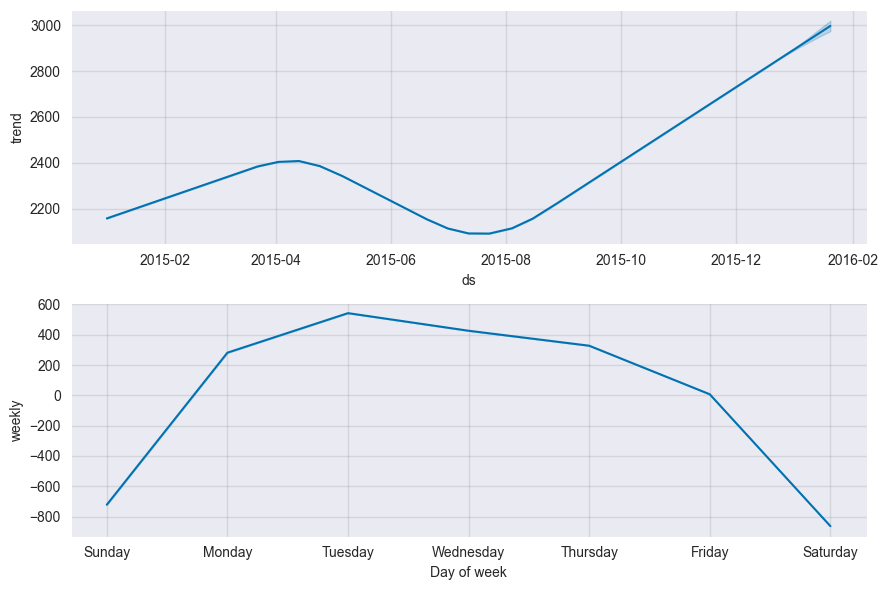

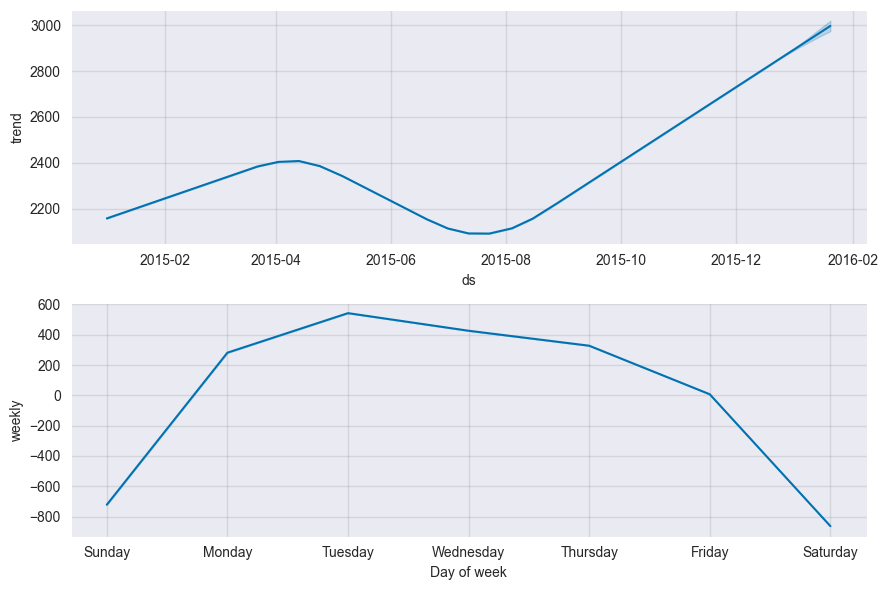

In [8]:
## ВАШ КОД для построения модели ##
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

m.plot_components(forecast)

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [9]:
## ВАШ КОД для оценки качества полученной модели ##
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
print('предсказанное число просмотров: ' + str(round(cmp_df.loc['2016-01-20']['yhat'])))

предсказанное число просмотров: 3422


**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

In [28]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
MAPE = (1/cmp_df.shape[0]) * sum((cmp_df['y'] - cmp_df['yhat']).abs() / cmp_df['y']) * 100
MAE = sum((cmp_df['y'] - cmp_df['yhat']).abs()) / cmp_df.shape[0]
print('MAPE', MAPE)
print('MAE', MAE)

MAPE 10.58288526822242
MAE 219.47561487820653


## Предсказываем с помощью ARIMA

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [21]:
## ВАШ КОД для проверки стационарности ряда ##
ful = sm.tsa.stattools.adfuller(df['y'])
print('p-value: ' + str(ful[1]))
if ful[1] < 0.05:
    print('Ряд является стационарным')
else:
    print('Ряд является нестационарным')

p-value: 0.01538366841946883
Ряд является стационарным


**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [24]:
## ВАШ КОД для построения модели ##
from itertools import product
ps = range(0, 3)
d = 1
qs = range(0, 1)
Ps = range(0, 3)
D = 1
Qs = range(0, 3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [29]:
best_aic = float('inf')
results = []
for param in parameters_list:
    model_1 = sm.tsa.statespace.SARIMAX(
        df['y'],
        order=(param[0], d, param[1]),
        seasonal_order=(param[2], D, param[3], 12)
    ).fit(disp=-1)
    aic = model_1.aic
    if aic < best_aic:
        best_model = model_1
        best_aic = aic
        best_param = param
    results.append([param, model_1.aic])

C:\Users\vm140\PycharmProjects\recommendation-systems\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\vm140\PycharmProjects\recommendation-systems\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\vm140\PycharmProjects\recommendation-systems\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\vm140\PycharmProjects\recommendation-systems\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\vm140\PycharmProjects\recommendation-systems\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided

In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
result_table.sort_values(by='aic', ascending=True) #Меньше - лучше

,parameters,aic
26,"(2, 0, 2, 2)",5725.747866
25,"(2, 0, 2, 1)",5732.965300
20,"(2, 0, 0, 2)",5804.289283
22,"(2, 0, 1, 1)",5808.373241
19,"(2, 0, 0, 1)",5814.151277
8,"(0, 0, 2, 2)",5816.777373
16,"(1, 0, 2, 1)",5817.698328
23,"(2, 0, 1, 2)",5818.220655
7,"(0, 0, 2, 1)",5818.533717
17,"(1, 0, 2, 2)",5819.369636
